In [1]:
import numpy as np
import sys
import gym
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import sys
import time
import pdb
import torch
from tqdm.notebook import tqdm
import pickle

import matplotlib.pyplot as plt

if '../' not in sys.path:
    sys.path.insert(0,'../')

from solvers import dqn
from solvers.models import dqndata, NeuralNet
from solvers.utils import eps_greedy
from solvers.visuals import *
from solvers.utils import greedy_policy

In [2]:
from torchvision import transforms
from PIL import Image

def phi_image(T):
    grayim = transforms.Compose(
        [transforms.Resize((128,128)),
         transforms.Grayscale(num_output_channels=1), transforms.ToTensor(),
         ])
    X = torch.zeros(len(T[0]),128,128)
    Xn = X
    for frame in range(len(T[0])):
        img = Image.fromarray((T[0][frame] * 255).astype(np.uint8))
        X[frame,:,:]  = grayim(img)
        img = Image.fromarray((T[2][frame] * 255).astype(np.uint8))
        Xn[frame,:,:]  = grayim(img) 
    
    X.requires_grad = True
    Xn.requires_grad = True
    R = torch.tensor(T[3]).float()
    
    return X, R, Xn



In [1]:
from gym.envs.atari.atari_env import AtariEnv

class env(AtariEnv):
    def __init__(self):
        super(env,self).__init__(game='space_invaders',obs_type='image',frameskip=4)
        env.reward_range = [-1,1]
    def step(self, a):
        reward = 0.0
        ob = []
        action = self._action_set[a]

        if isinstance(self.frameskip, int):
            num_steps = self.frameskip
        else:
            raise NotImplementedError()
        for s in range(num_steps):
            reward += self.ale.act(action)
            ob.append(self._get_obs())
        return ob, reward, self.ale.game_over(), {"ale.lives": self.ale.lives()}
env = env()

In [17]:
from IPython import display

env.reset()
score = 0
replaymem = []
step = 1
render = False
while True:
    action = env.action_space.sample()
    ob,reward,done,info = env.step(action) # take a random action
    X, R,_ = phi_image([ob,0,ob,reward])
    replaymem.append([X,0,action])
    score += reward
    if not render:
        sys.stdout.write("\r" + "Step: "+ str(step)+ "\t Observation: "+
                         str(np.shape(ob)) + "\t Rewards: " +  str(score) + "\t Lives: " + str(info)
                        )
        sys.stdout.flush()
        time.sleep(0.1)
    step+=1
    if render:
        fig = plt.figure(figsize=(8,8))
        for i,frame in enumerate(ob):
            ax = fig.add_subplot(2,2,i+1)
            ax.imshow(frame)
            ax.set_title('frame%d'%i)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.1)
    if done :
        break
        
print('\n Total reward: {} in {} steps'.format(score, step))



Step: 460	 Observation: (4, 210, 160, 3)	 Rewards: 120.0	 Lives: {'ale.lives': 0}
 Total reward: 120.0 in 461 steps


torch.Size([4, 128, 128])


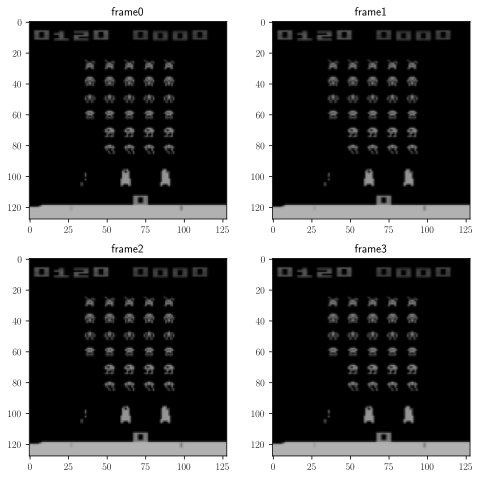

<module 'matplotlib.pyplot' from '/projects/academic/olgawodo/kiranvad/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [11]:
imtensor, R, _ = phi_image([ob,0,ob,reward])
print(imtensor.shape)
fig = plt.figure(figsize=(8,8))
for i in range(imtensor.shape[0]):
    npimage = imtensor[i].detach().numpy()
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(npimage,cmap='gray', vmin=0, vmax=1)
    ax.set_title('frame%d'%i)
plt.show()
plt

Please be aware of the following pre-processing steps for Atari usage:
1. https://github.com/openai/gym/issues/275
2. https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/

In [12]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pdb

from solvers.models import ataridata
D = ataridata(replaymem)
dataloader = DataLoader(D, batch_size=8, shuffle=True)
X,y,action = next(iter(dataloader))
print(X.shape,y,action)

torch.Size([8, 4, 128, 128]) tensor([0, 0, 0, 0, 0, 0, 0, 0]) tensor([5, 4, 4, 2, 0, 4, 5, 0])


In [13]:
from solvers.models import Convnet
model = Convnet(env, num_channels=4)
yb = model.forward(X)
print('train:',X.shape,yb.shape) # train mode'
x = X[1,].unsqueeze(0)
y = model.forward(x)
print('predict: ',x.shape, y.shape)


train: torch.Size([8, 4, 128, 128]) torch.Size([8, 6])
predict:  torch.Size([1, 4, 128, 128]) torch.Size([1, 6])
